#### 简单尝试

In [1]:
# import json
import lightgbm as lgb
import pandas as pd
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
print('load data...')
df_train = pd.read_csv('./data/regression.train.txt',header=None,sep='\t')
df_test = pd.read_csv('./data/regression.test.txt',header=None,sep='\t')
# df_train.head()

load data...


In [3]:
#切分数据集
y_train = df_train[0].values
y_test = df_test[0].values
X_train = df_train.drop(0,axis=1).values
X_test = df_test.drop(0,axis=1).values

In [4]:
#将数据集转换为lightgbm格式
lgb_train = lgb.Dataset(X_train,y_train)
lgb_eval = lgb.Dataset(X_test,y_test,reference=lgb_train)

In [5]:
params = {
    'task':'train',
    'boosting_type':'gbdt',
    'objective':'regression',
    'metric':{'l2','mse'},
    'num_leaves':31,    #单棵树的叶子节点
    'learning_rate':0.05,
    'feature_fraction':0.9,
    'bagging_fraction':0.8,
    'bagging_freq':5,
    'verbose':0
}
print('开始训练...')
gbm = lgb.train(params,
                lgb_train,
               num_boost_round=500,
               valid_sets=lgb_eval,
               early_stopping_rounds=10)

print('保存模型...')
gbm.save_model('model.txt')

print('开始预测...')
y_pred = gbm.predict(X_test,num_iteration=gbm.best_iteration)

print('预估结果的mse为:')
print(mean_squared_error(y_test,y_pred))

开始训练...
[1]	valid_0's l2: 0.24288	valid_0's l2: 0.24288
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 0.239307	valid_0's l2: 0.239307
[3]	valid_0's l2: 0.235559	valid_0's l2: 0.235559
[4]	valid_0's l2: 0.230771	valid_0's l2: 0.230771
[5]	valid_0's l2: 0.226297	valid_0's l2: 0.226297
[6]	valid_0's l2: 0.223692	valid_0's l2: 0.223692
[7]	valid_0's l2: 0.220941	valid_0's l2: 0.220941
[8]	valid_0's l2: 0.217982	valid_0's l2: 0.217982
[9]	valid_0's l2: 0.215351	valid_0's l2: 0.215351
[10]	valid_0's l2: 0.213064	valid_0's l2: 0.213064
[11]	valid_0's l2: 0.211053	valid_0's l2: 0.211053
[12]	valid_0's l2: 0.209336	valid_0's l2: 0.209336
[13]	valid_0's l2: 0.207492	valid_0's l2: 0.207492
[14]	valid_0's l2: 0.206016	valid_0's l2: 0.206016
[15]	valid_0's l2: 0.204677	valid_0's l2: 0.204677
[16]	valid_0's l2: 0.203224	valid_0's l2: 0.203224
[17]	valid_0's l2: 0.201186	valid_0's l2: 0.201186
[18]	valid_0's l2: 0.199626	valid_0's l2: 0.199626
[19]	valid_0's l2: 0.19

#### 带权重的模型训练

In [6]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [7]:
print("加载数据...")
df_train = pd.read_csv('./data/binary.train',header=None,sep='\t')
df_test = pd.read_csv('./data/binary.test',header=None,sep='\t')
W_train = pd.read_csv('./data/binary.train.weight',header=None)
W_test = pd.read_csv('./data/binary.test.weight',header=None)

加载数据...


In [8]:
y_train = df_train[0].values
y_test = df_test[0].values
X_train = df_train.drop(0,axis=1).values
X_test = df_test.drop(0,axis=1).values

In [9]:
num_train,num_feature = X_train.shape
X_train.shape

(7000, 28)

In [10]:
lgb_train = lgb.Dataset(X_train,y_train,weight=W_train,free_raw_data=False)
lgb_eval = lgb.Dataset(X_test,y_test,weight=W_test,free_raw_data=False) #如果为真，则在构造内部数据集之后释放原始数据。

In [11]:
params = {
    'boosting_type':'gbdt',
    'objective':'binary',
    'metric':'binary_logloss',
    'num_leaves':31,
    'learning_rate':0.05,
    'feature_fraction':0.9,  #对特征进行抽样
    'bagging_fraction':0.8,  #类似上面，但是它在不进行重采样的情况下随机选择部分数据
    'bagging_freq':5,  #启用bagging的频率，每5次迭代执行bagging
    'verbose':0
}

feature_name = ['feature_'+str(col) for col in range(num_feature)]

print('开始训练...')
gbm = lgb.train(params,
               lgb_train,
               num_boost_round=10,
               valid_sets=lgb_train,
               feature_name=feature_name,
               categorical_feature=[21])  #categorical_feature指定第21位为分类特征

开始训练...
[1]	training's binary_logloss: 0.680298
[2]	training's binary_logloss: 0.672021
[3]	training's binary_logloss: 0.664444
[4]	training's binary_logloss: 0.655536
[5]	training's binary_logloss: 0.647375
[6]	training's binary_logloss: 0.640788
[7]	training's binary_logloss: 0.635012
[8]	training's binary_logloss: 0.628454
[9]	training's binary_logloss: 0.622423
[10]	training's binary_logloss: 0.616808


In [12]:
print('完成10轮训练...')
print('第七个特征为：')
print(repr(lgb_train.feature_name[6]))  #repr返回一个对象的 string 格式

完成10轮训练...
第七个特征为：
'feature_6'


In [13]:
#存储模型
gbm.save_model('./lgb_model.txt')
# 特征名称
print('特征名称:')
print(gbm.feature_name())

# 特征重要度
print('特征重要度:')
print(list(gbm.feature_importance()))

特征名称:
['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27']
特征重要度:
[8, 4, 0, 19, 8, 36, 3, 0, 2, 10, 5, 1, 0, 9, 5, 3, 0, 2, 2, 5, 1, 0, 35, 3, 28, 45, 31, 35]


In [14]:
print('加载模型用于预测：')
bst = lgb.Booster(model_file='./lgb_model.txt')  #booster初始化一个模型
y_pred = bst.predict(X_test)
print('在测试集上的mse为：')
print(mean_squared_error(y_test,y_pred))

加载模型用于预测：
在测试集上的mse为：
0.21327677116620622


#### 继续训练

In [15]:
gbm = lgb.train(params,
               lgb_train,
               num_boost_round=10,
               init_model='./lgb_model.txt',
                feature_name=feature_name,
               valid_sets=lgb_eval)
print('以旧模型为初始化，完成第10-20轮训练...')

[11]	valid_0's binary_logloss: 0.613941
[12]	valid_0's binary_logloss: 0.610317
[13]	valid_0's binary_logloss: 0.606257
[14]	valid_0's binary_logloss: 0.601789
[15]	valid_0's binary_logloss: 0.597803
[16]	valid_0's binary_logloss: 0.594579
[17]	valid_0's binary_logloss: 0.590794
[18]	valid_0's binary_logloss: 0.58741
[19]	valid_0's binary_logloss: 0.584296
[20]	valid_0's binary_logloss: 0.581739
以旧模型为初始化，完成第10-20轮训练...


In [16]:
#在训练过程中调整学习率
gbm =lgb.train(params,
     lgb_train,
     num_boost_round=10,
     init_model=gbm,
     learning_rates=lambda iter:0.05*(0.99**iter),
    feature_name=feature_name,
     valid_sets= lgb_eval)
print('逐步调整学习率完成第20-30轮训练...')

[21]	valid_0's binary_logloss: 0.613941
[22]	valid_0's binary_logloss: 0.610352
[23]	valid_0's binary_logloss: 0.60637
[24]	valid_0's binary_logloss: 0.602024
[25]	valid_0's binary_logloss: 0.598221
[26]	valid_0's binary_logloss: 0.595039
[27]	valid_0's binary_logloss: 0.591429
[28]	valid_0's binary_logloss: 0.588352
[29]	valid_0's binary_logloss: 0.585486
[30]	valid_0's binary_logloss: 0.582613
逐步调整学习率完成第20-30轮训练...


In [17]:
#调整bagging迭代频次
gbm = lgb.train(params,
               lgb_train,
               num_boost_round=10,
               init_model=gbm,
               learning_rates=lambda iter:0.05*(0.09**iter),
                feature_name=feature_name,
               valid_sets=lgb_eval)
print('逐步调整bagging比率完成第30-40轮训练...')

[31]	valid_0's binary_logloss: 0.613941
[32]	valid_0's binary_logloss: 0.613605
[33]	valid_0's binary_logloss: 0.613563
[34]	valid_0's binary_logloss: 0.613559
[35]	valid_0's binary_logloss: 0.613559
[36]	valid_0's binary_logloss: 0.613559
[37]	valid_0's binary_logloss: 0.613559
[38]	valid_0's binary_logloss: 0.613559
[39]	valid_0's binary_logloss: 0.613559
[40]	valid_0's binary_logloss: 0.613559
逐步调整bagging比率完成第30-40轮训练...


#### sklearn与lightgbm配合使用

In [18]:
import lightgbm as lgb
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [19]:
print('加载数据...')
df_train = pd.read_csv('./data/regression.train.txt',header=None,sep='\t')
df_test = pd.read_csv('./data/regression.test.txt',header=None,sep='\t')

加载数据...


In [20]:
y_train = df_train[0].values
y_test = df_train[0].values
X_train = df_train.drop(0,axis=1).values
X_test = df_train.drop(0,axis=1).values

In [21]:
print('开始训练...')
gbm = lgb.LGBMRegressor(objective='regression',
                       num_leaves=31,
                       learning_rate=0.05,
                       n_estimators=20)

gbm.fit(X_train,y_train,
       eval_set=[(X_test,y_test)],
       eval_metric='l1',
       early_stopping_rounds=5)

开始训练...
[1]	valid_0's l1: 0.492619	valid_0's l2: 0.243708
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.487445	valid_0's l2: 0.238853
[3]	valid_0's l1: 0.482285	valid_0's l2: 0.23421
[4]	valid_0's l1: 0.477567	valid_0's l2: 0.230131
[5]	valid_0's l1: 0.472999	valid_0's l2: 0.226307
[6]	valid_0's l1: 0.468568	valid_0's l2: 0.222722
[7]	valid_0's l1: 0.464402	valid_0's l2: 0.219475
[8]	valid_0's l1: 0.460408	valid_0's l2: 0.216391
[9]	valid_0's l1: 0.456505	valid_0's l2: 0.213513
[10]	valid_0's l1: 0.452615	valid_0's l2: 0.210739
[11]	valid_0's l1: 0.448894	valid_0's l2: 0.208095
[12]	valid_0's l1: 0.445385	valid_0's l2: 0.205678
[13]	valid_0's l1: 0.441912	valid_0's l2: 0.203401
[14]	valid_0's l1: 0.438673	valid_0's l2: 0.201276
[15]	valid_0's l1: 0.435496	valid_0's l2: 0.19928
[16]	valid_0's l1: 0.432459	valid_0's l2: 0.197352
[17]	valid_0's l1: 0.429641	valid_0's l2: 0.195612
[18]	valid_0's l1: 0.426743	valid_0's l2: 0.193824
[19]	valid_0's l1: 0.423

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.05, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=20, n_jobs=-1, num_leaves=31, objective='regression',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [22]:
print('开始预测...')
y_pred = gbm.predict(X_test,num_iteration=gbm.best_iteration_)

开始预测...


In [23]:
print('预测结果的mse是：')
print(mean_squared_error(y_test,y_pred))

预测结果的mse是：
0.1906709487358305


In [24]:
#配合sklearn的cv选择超参数
estimator = lgb.LGBMRegressor(num_leaves=31)

param_grid = {
    'learning_rate':[0.01,0.1,1],
    'n_estimators':[20,40]
}

gbm = GridSearchCV(estimator,param_grid)
gbm.fit(X_train,y_train)
print('用网格搜索找到的最优超参数为：')
print(gbm.best_params_)

用网格搜索找到的最优超参数为：
{'learning_rate': 0.1, 'n_estimators': 40}


#### 绘图解释

In [25]:
import lightgbm as lgb
import pandas as pd
import graphviz
%matplotlib inline
try:
    import matplotlib.pyplot as plt
except ImportError:
    raise ImportError('You need to install matplotlib for plotting.')


In [26]:
# 加载数据集
print('加载数据...')
df_train = pd.read_csv('./data/regression.train.txt', header=None, sep='\t')
df_test = pd.read_csv('./data/regression.test.txt', header=None, sep='\t')

加载数据...


In [27]:
# 取出特征和标签
y_train = df_train[0].values
y_test = df_test[0].values
X_train = df_train.drop(0, axis=1).values
X_test = df_test.drop(0, axis=1).values

In [28]:
# 构建lgb中的Dataset数据格式
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [29]:
# 设定参数
params = {
    'num_leaves': 5,
    'metric': ('l1', 'l2'),
    'verbose': 0
}

evals_result = {}  # to record eval results for plotting

In [30]:
print('开始训练...')
# 训练
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100,
                valid_sets=[lgb_train, lgb_test],
                feature_name=['f' + str(i + 1) for i in range(28)],
                categorical_feature=[21],
                evals_result=evals_result,
                verbose_eval=10)

开始训练...
[10]	training's l1: 0.457448	training's l2: 0.217995	valid_1's l1: 0.456464	valid_1's l2: 0.21641
[20]	training's l1: 0.436869	training's l2: 0.205099	valid_1's l1: 0.434057	valid_1's l2: 0.201616
[30]	training's l1: 0.421302	training's l2: 0.197421	valid_1's l1: 0.417019	valid_1's l2: 0.192514
[40]	training's l1: 0.411107	training's l2: 0.192856	valid_1's l1: 0.406303	valid_1's l2: 0.187258
[50]	training's l1: 0.403695	training's l2: 0.189593	valid_1's l1: 0.398997	valid_1's l2: 0.183688
[60]	training's l1: 0.398704	training's l2: 0.187043	valid_1's l1: 0.393977	valid_1's l2: 0.181009
[70]	training's l1: 0.394876	training's l2: 0.184982	valid_1's l1: 0.389805	valid_1's l2: 0.178803
[80]	training's l1: 0.391147	training's l2: 0.1828	valid_1's l1: 0.386476	valid_1's l2: 0.176799
[90]	training's l1: 0.388101	training's l2: 0.180817	valid_1's l1: 0.384404	valid_1's l2: 0.175775
[100]	training's l1: 0.385174	training's l2: 0.179171	valid_1's l1: 0.382929	valid_1's l2: 0.175321


在训练过程中绘图...


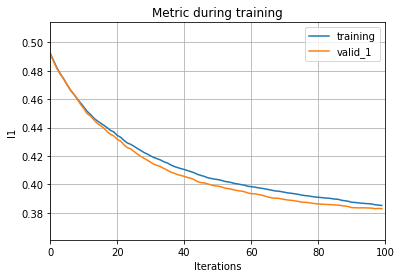

In [31]:
print('在训练过程中绘图...')
ax = lgb.plot_metric(evals_result, metric='l1')
plt.show()

画出特征重要度...


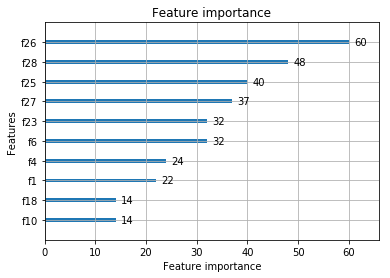

In [32]:
print('画出特征重要度...')
ax = lgb.plot_importance(gbm, max_num_features=10)
plt.show()

画出第84颗树...


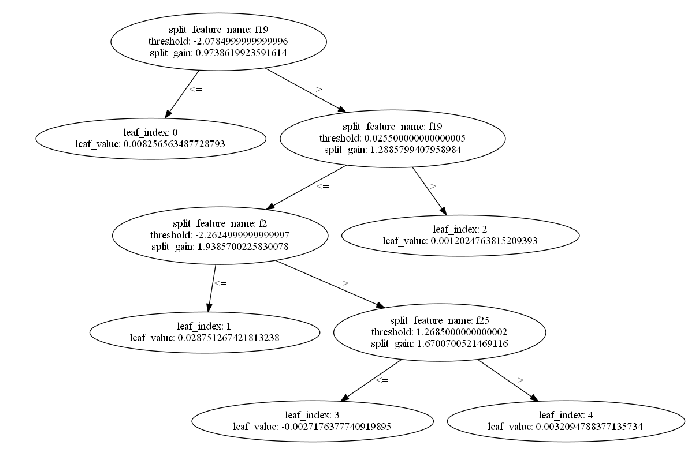

In [33]:
print('画出第84颗树...')
ax = lgb.plot_tree(gbm, tree_index=83, figsize=(20, 8), show_info=['split_gain'])
plt.show()

In [34]:
print('用graphviz画出第84颗树...')
graph = lgb.create_tree_digraph(gbm, tree_index=83, name='Tree84')
graph.render(view=True)

用graphviz画出第84颗树...


'Tree84.gv.pdf'